## Binary classification with Lightweight CNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset


### 1. Import libraries

In [1]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data

In [2]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data 
- We train using the training set and save the model that gives the best performance on the validation set

In [3]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. Lightweight CNN model

Let's define our simple CNN architecture which has one conv layer and one FC layer

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self,chan_total,signal_length):
        super(CNN_Model, self).__init__()
        self.stride=1
        self.k_val=5
        # conv: (chan x signal)--> (chan x signal/stride)
        self.conv1 = nn.Conv1d(in_channels=chan_total, out_channels=chan_total, kernel_size=2*self.k_val+self.stride, stride=self.stride,padding=self.k_val) #k=lpc order ?#oc=2,k=4
        # pool: (chan x signal/stride) --> (chan x 1)
        self.pool1 = nn.AvgPool1d(kernel_size=int(signal_length/self.stride))
        self.input_s=int(chan_total)
        self.fc = nn.Linear(self.input_s, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool1(x)
        x = x.view(-1, self.input_s)
        x=self.fc(x)
        return x

### 5. Initialize model

In [51]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = CNN_Model(n_chan,n_datalength)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [52]:
batch_size = 2#1
num_epochs = 80
lrate=1e-4
patience=80 # no early stopping from paper
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lrate)
cnn_modelfullpath=os.path.join(cnn_modelpath,'light_cnn.pt')

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 7. Prepare data

In [53]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [54]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/80: 100%|██████████| 161/161 [00:00<00:00, 162.10it/s]


model state saved with validation accuracy: 60.1449


Epoch 2/80: 100%|██████████| 161/161 [00:00<00:00, 166.35it/s]


model state saved with validation accuracy: 67.3913


Epoch 3/80: 100%|██████████| 161/161 [00:00<00:00, 166.21it/s]


model state saved with validation accuracy: 73.9130


Epoch 5/80: 100%|██████████| 161/161 [00:00<00:00, 168.73it/s]


model state saved with validation accuracy: 77.5362


Epoch 7/80: 100%|██████████| 161/161 [00:00<00:00, 172.53it/s]


model state saved with validation accuracy: 81.8841


Epoch 9/80: 100%|██████████| 161/161 [00:00<00:00, 168.09it/s]


model state saved with validation accuracy: 83.3333


Epoch 12/80: 100%|██████████| 161/161 [00:00<00:00, 163.98it/s]


model state saved with validation accuracy: 86.2319


Epoch 13/80: 100%|██████████| 161/161 [00:00<00:00, 174.68it/s]


model state saved with validation accuracy: 87.6812


Epoch 17/80: 100%|██████████| 161/161 [00:01<00:00, 155.15it/s]


model state saved with validation accuracy: 89.1304


Epoch 25/80: 100%|██████████| 161/161 [00:00<00:00, 168.10it/s]


model state saved with validation accuracy: 89.8551


Epoch 28/80: 100%|██████████| 161/161 [00:00<00:00, 171.24it/s]


model state saved with validation accuracy: 90.5797


Epoch 29/80: 100%|██████████| 161/161 [00:00<00:00, 165.02it/s]


model state saved with validation accuracy: 92.0290


Epoch 31/80: 100%|██████████| 161/161 [00:00<00:00, 161.66it/s]


model state saved with validation accuracy: 92.7536


Epoch 39/80: 100%|██████████| 161/161 [00:00<00:00, 166.11it/s]


model state saved with validation accuracy: 93.4783


Epoch 47/80: 100%|██████████| 161/161 [00:00<00:00, 164.58it/s]


model state saved with validation accuracy: 94.2029


Epoch 48/80: 100%|██████████| 161/161 [00:00<00:00, 163.42it/s]


model state saved with validation accuracy: 94.9275


Epoch 57/80: 100%|██████████| 161/161 [00:01<00:00, 154.47it/s]


model state saved with validation accuracy: 95.6522


Epoch 59/80: 100%|██████████| 161/161 [00:00<00:00, 169.43it/s]


model state saved with validation accuracy: 96.3768


Epoch 70/80: 100%|██████████| 161/161 [00:01<00:00, 154.11it/s]


model state saved with validation accuracy: 97.1014


Epoch 80/80: 100%|██████████| 161/161 [00:00<00:00, 169.39it/s]


### 9. Inspect training process

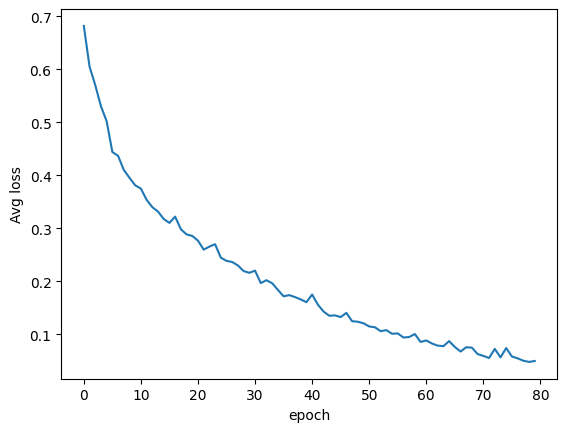

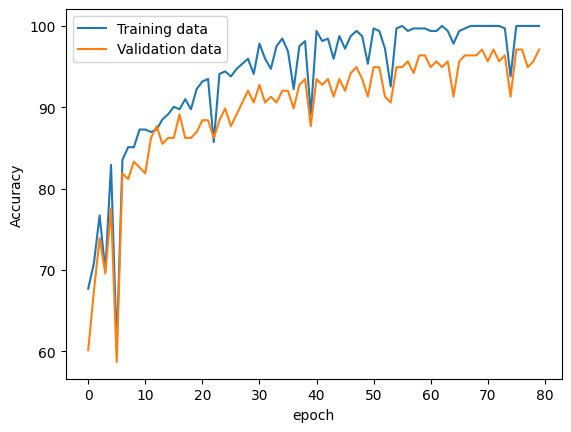

In [55]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [56]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 100.0000
Confusion Matrix:
[[168   0]
 [  0 154]]
Accuracy: 100.0
Precision: 100.0
Sensitivity (Recall): 100.0
Specificity: 100.0
F1 Score: 1.0
AUC Score: 1.0


Validation Binary Accuracy: 97.1014
Confusion Matrix:
[[69  3]
 [ 1 65]]
Accuracy: 97.10144927536231
Precision: 95.58823529411765
Sensitivity (Recall): 98.48484848484848
Specificity: 95.83333333333334
F1 Score: 0.9701492537313432
AUC Score: 0.9968434343434344


Test Binary Accuracy: 98.9130
Confusion Matrix:
[[48  0]
 [ 1 43]]
Accuracy: 98.91304347826086
Precision: 100.0
Sensitivity (Recall): 97.72727272727273
Specificity: 100.0
F1 Score: 0.9885057471264368
AUC Score: 0.9976325757575758
Completed
